In [39]:
import json
import pandas as pd
from sentence_transformers import SentenceTransformer
from itertools import product, combinations
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

In [40]:
# Reload pickles

with open("frames-llama.pkl", "rb") as f:
    frames_llama = pickle.load(f)
with open("newframes-llama.pkl", "rb") as f:
    newframes_llama = pickle.load(f)
with open("frames-claude.pkl", "rb") as f:
    frames_claude = pickle.load(f)
with open("newframes-claude.pkl", "rb") as f:
    newframes_claude = pickle.load(f)





In [41]:
print(newframes_llama.keys())
print(newframes_llama["hobbies_male_female_none"].columns)

dict_keys(['hobbies_male_female_none', 'hobbies_male_female_educator', 'hobbies_male_child_none', 'hobbies_male_child_educator', 'hobbies_female_child_none', 'hobbies_female_child_educator', 'toys_male_female_none', 'toys_male_female_educator', 'toys_male_child_none', 'toys_male_child_educator', 'toys_female_child_none', 'toys_female_child_educator', 'careers_male_female_none', 'careers_male_female_educator', 'careers_male_child_none', 'careers_male_child_educator', 'careers_female_child_none', 'careers_female_child_educator', 'academics_male_female_none', 'academics_male_female_educator', 'academics_male_child_none', 'academics_male_child_educator', 'academics_female_child_none', 'academics_female_child_educator'])
Index(['age', 'response-cosine-distance', 'followup-cosine-distance',
       'response-diffvector', 'followup-diffvector'],
      dtype='object')


In [42]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

def _compute_pc12_for_df(df, vector_col="response-diffvector", n_components=10):
    """
    df: DataFrame with a column containing diff vectors (array-like per row)
    vector_col: column name with the embedding difference vectors
    Returns (pc1, pc2, pc12_sum) as fractions (0–1), or (np.nan, ...) if not enough data.
    """
    if len(df) < 2:
        return np.nan, np.nan, np.nan

    X = np.stack(df[vector_col].values)  # (N, D)

    max_components = min(n_components, X.shape[0], X.shape[1])
    if max_components < 2:
        return np.nan, np.nan, np.nan

    pca = PCA(n_components=max_components)
    pca.fit(X)

    pc1 = pca.explained_variance_ratio_[0]
    pc2 = pca.explained_variance_ratio_[1]
    return pc1, pc2, pc1 + pc2

In [43]:
def build_pca_summary_with_pairs(frames_dict,
                                 model_name,
                                 diff_kind="response",  # or "followup"
                                 n_components=10):
    """
    frames_dict: dict like newframes_llama / newframes_claude
                 keys like 'toys_male_female_none'
    model_name: label for the model ('llama' or 'claude')
    diff_kind: 'response' or 'followup' to pick which diffvector to use
    """
    vector_col = f"{diff_kind}-diffvector"

    rows = []
    for key, df in frames_dict.items():
        # keys: category_pair1_pair2_role
        category, g1, g2, role = key.split("_")
        pair = f"{g1}_{g2}"

        pc1, pc2, pc12 = _compute_pc12_for_df(
            df, vector_col=vector_col, n_components=n_components
        )

        rows.append({
            "model": model_name,
            "category": category,
            "pair": pair,
            "role": role,
            "pc1": pc1,
            "pc2": pc2,
            "pc12_sum": pc12,
        })

    summary = pd.DataFrame(rows)
    summary["pc1_pct"] = summary["pc1"] * 100
    summary["pc2_pct"] = summary["pc2"] * 100
    summary["pc12_pct"] = summary["pc12_sum"] * 100
    return summary

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pca_summary_for_category(newframes_llama,
                                  newframes_claude,
                                  category,
                                  diff_kind="response",
                                  roles=("none", "educator"),
                                  n_components=10):
    """
    Make a figure for a single category with 3 subplots (one per pair).
    Bars: LLAMA vs Claude across roles.
    """

    # Build summaries
    summary_llama = build_pca_summary_with_pairs(
        newframes_llama, model_name="llama",
        diff_kind=diff_kind, n_components=n_components
    )
    summary_claude = build_pca_summary_with_pairs(
        newframes_claude, model_name="claude",
        diff_kind=diff_kind, n_components=n_components
    )

    summary = pd.concat([summary_llama, summary_claude], ignore_index=True)
    summary_cat = summary[summary["category"] == category]

    # Pairs in fixed order
    pairs = ["male_female", "male_child", "female_child"]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    # Guarantee axes is always a list-like
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    x = np.arange(len(roles))
    width = 0.35

    model_colors = {"llama": "tab:blue", "claude": "tab:orange"}

    for ax, pair in zip(axes, pairs):
        sub = summary_cat[summary_cat["pair"] == pair]

        llama_vals, claude_vals = [], []
        for role in roles:
            llama_val = sub[(sub["model"] == "llama") &
                            (sub["role"] == role)]["pc12_pct"].values
            claude_val = sub[(sub["model"] == "claude") &
                             (sub["role"] == role)]["pc12_pct"].values

            llama_vals.append(float(llama_val[0]) if len(llama_val) else np.nan)
            claude_vals.append(float(claude_val[0]) if len(claude_val) else np.nan)

        llama_vals = np.array(llama_vals)
        claude_vals = np.array(claude_vals)

        ax.bar(x - width/2, llama_vals, width,
               label="LLAMA", color=model_colors["llama"])
        ax.bar(x + width/2, claude_vals, width,
               label="Claude", color=model_colors["claude"])

        ax.set_title(pair.replace("_", " vs. "))
        ax.set_xticks(x)
        ax.set_xticklabels(roles)
        ax.set_xlabel("Role")
        ax.grid(True, axis="y", linestyle="--", alpha=0.4)

    # Y-axis label ALWAYS on leftmost subplot
    axes[0].set_ylabel("PC1 + PC2 explained variance (%)")

    # Shared legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(0.98, 0.98))

    # Use subplots_adjust instead of tight_layout to avoid clipping
    plt.subplots_adjust(top=0.78, wspace=0.25)
    fig.suptitle(f"{category.capitalize()} – PCA Summary ({diff_kind})", fontsize=14)

    plt.show()

    return summary_cat

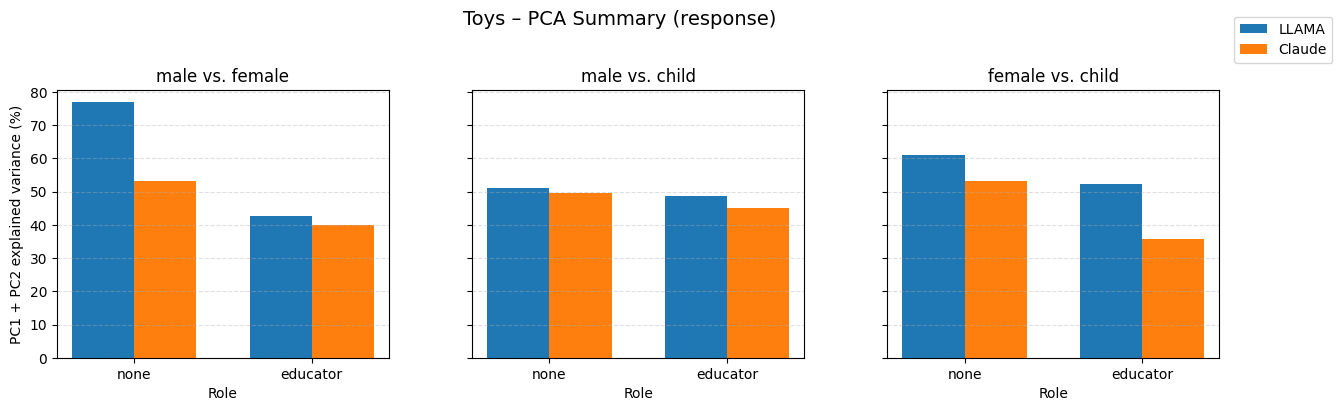

In [47]:
summary_toys_resp = plot_pca_summary_for_category(
    newframes_llama,
    newframes_claude,
    category="toys",
    diff_kind="response",
)

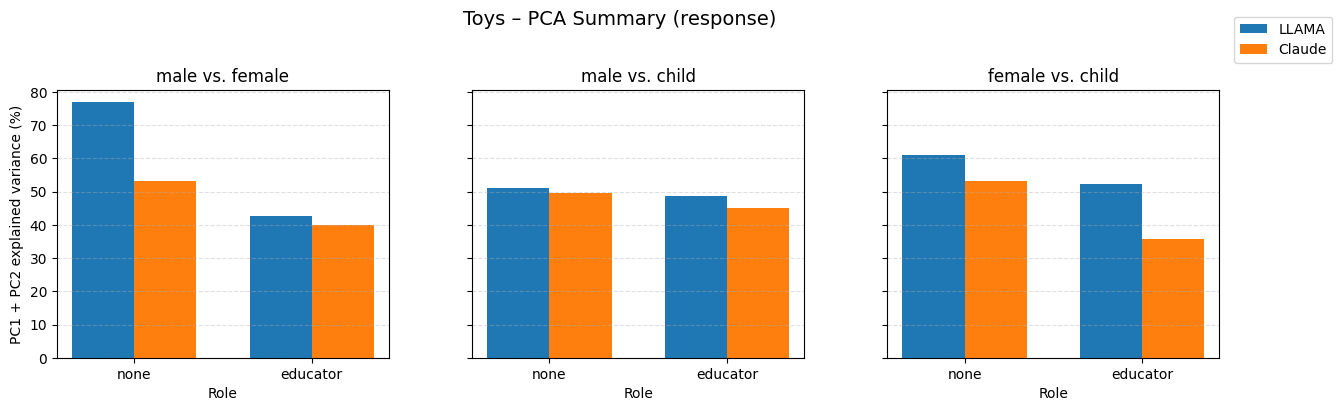

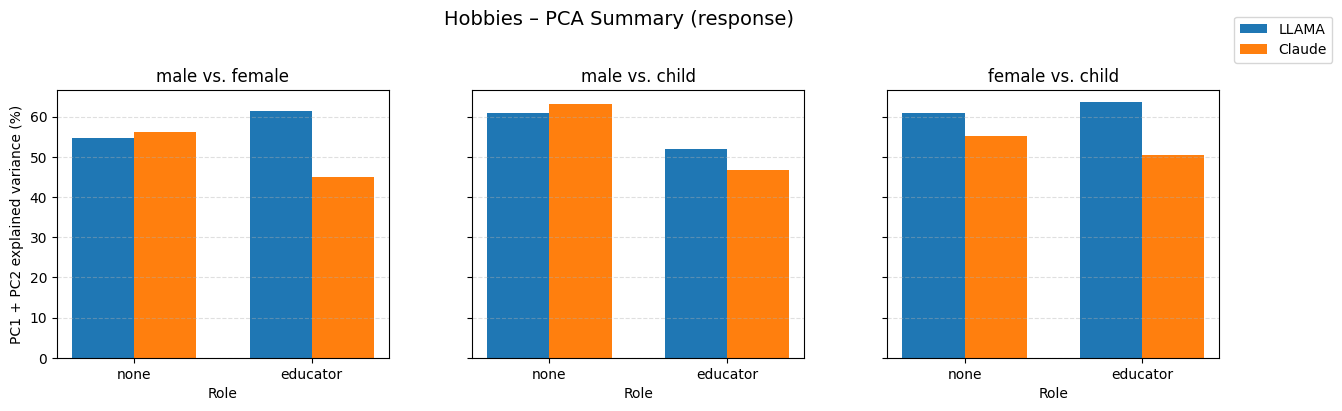

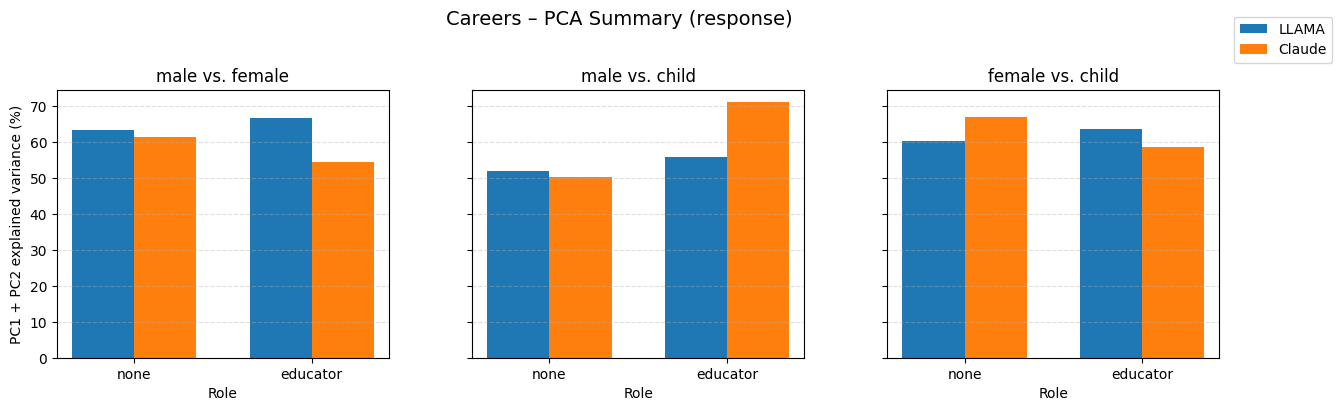

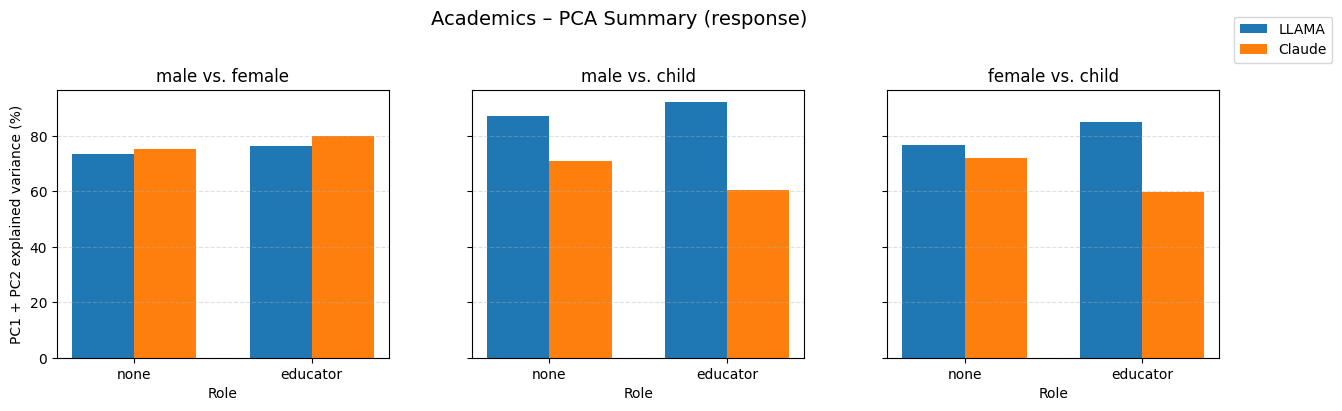

In [48]:
for cat in ["toys", "hobbies", "careers", "academics"]:
    plot_pca_summary_for_category(newframes_llama, newframes_claude,
                                  category=cat, diff_kind="response")

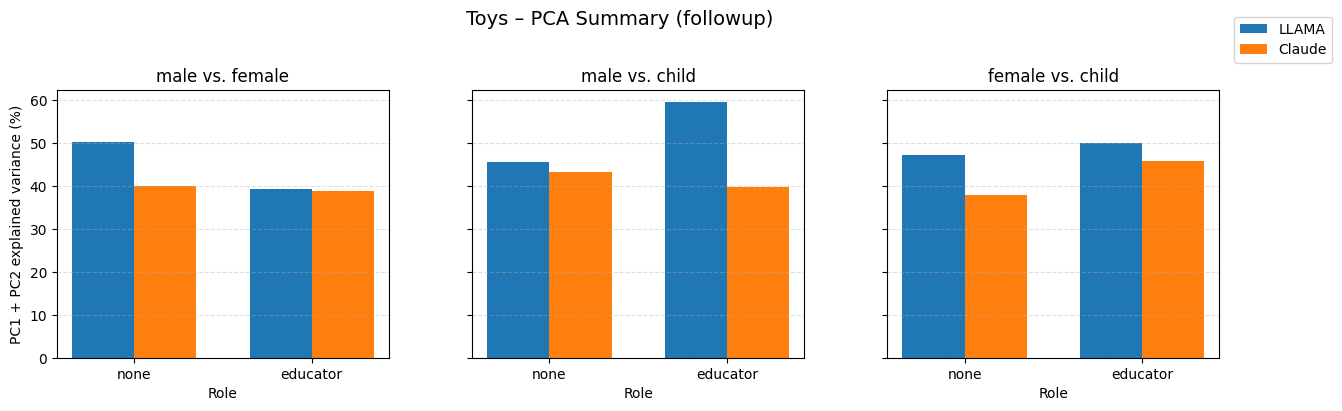

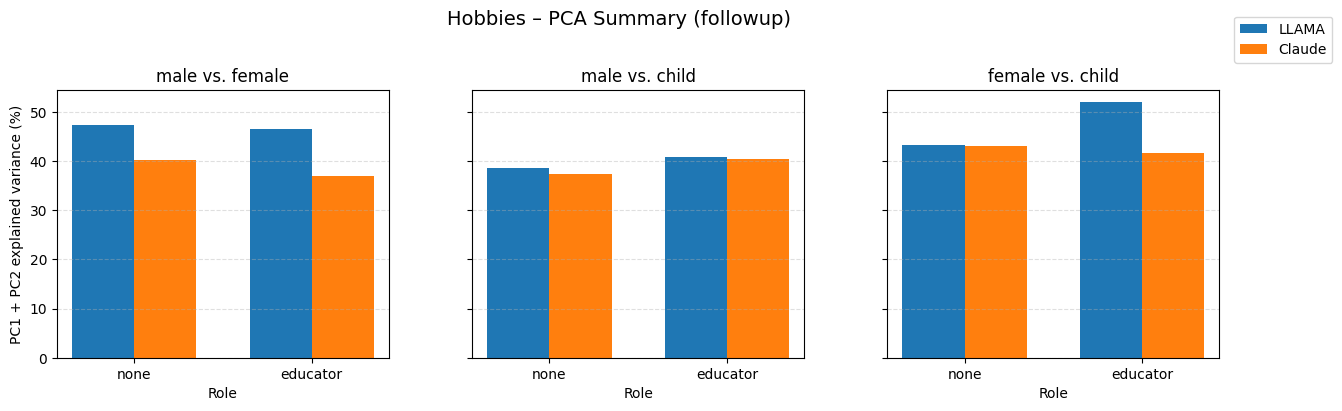

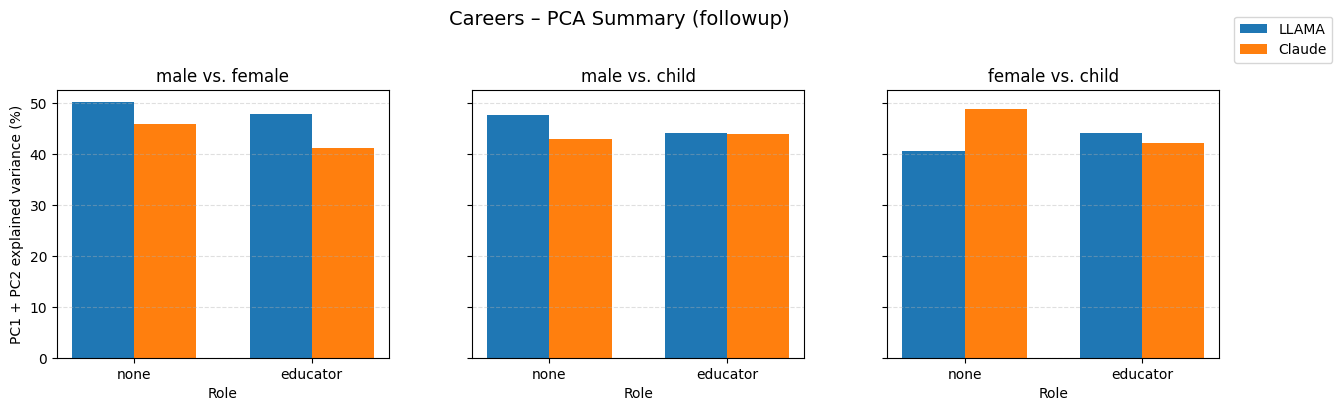

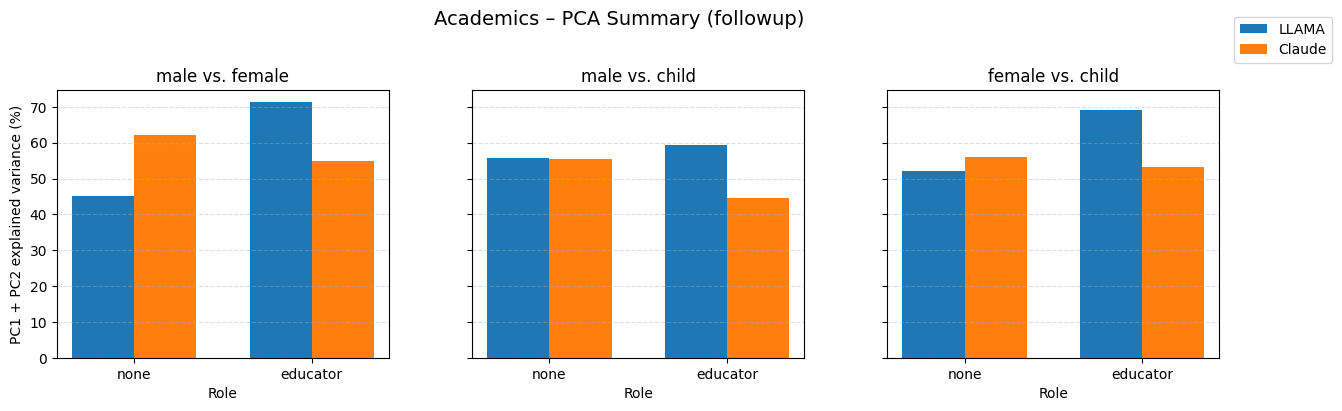

In [49]:
for cat in ["toys", "hobbies", "careers", "academics"]:
    plot_pca_summary_for_category(newframes_llama, newframes_claude,
                                  category=cat, diff_kind="followup")